In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from numpy import linalg as LA


Following the function for: missclassification error, Hinge Loss, and Huber-Hinge-Loss:

In [77]:
def missClassError(x):
    if x>0:
        return 0
    else:
        return 1
def hingeLoss(x):
    if 1-x>0:
        return 1-x
    else:
        return 0
    return np.max(0,1-x)
def huberHingeLoss(y,t,h):
    if (y*t >1+h):
        return 0
    elif((1-y*t)<=h and (y*t-1)<=h):
        return ((1+h-y*t)**2)/(4*h)
    elif(y*t <1-h):
        return (1-y*t)

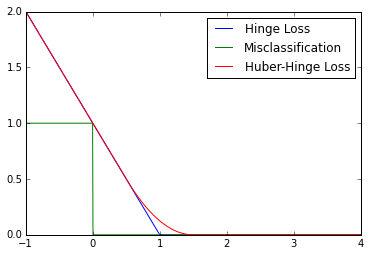

In [81]:
x=np.linspace(-1,5,1000)
yHinge = []
yMissClass = []
hinge=[]
for i in x:
    yHinge.append(hingeLoss(i))
    yMissClass.append(missClassError(i))
    hinge.append(huberHingeLoss(i,1,0.5))
plt.plot(x,yHinge,label="Hinge Loss")
plt.plot(x,yMissClass,label="Misclassification")
plt.plot(x,hinge,label="Huber-Hinge Loss")
plt.legend(loc='upper right')
plt.xlim(-1,4)
plt.ylim(0,2)

plt.show()

The Huber Hinge loss function is defined as:
$$
l_{huber-hunge}(y,t) = \begin{cases} 0, & \mbox{if } yt>1+h\\ 
\frac{(1+h-yt)^2}{4h}, & \mbox{if } |1-yt|\le h \\
1-yt, & \mbox{if } yt< 1-h
\end{cases}
$$
The huber-hunge function is differentiable because is a picewise function differentiable in the trhee region where is defined: $(-\infty,1-h)$,$(1-h,1+h)$ and $(1+h,+\infty)$. And because it is continuous in the two joining point, infact:
$$
\lim_{yt\rightarrow(1-h)^-}l_{huber-hunge}(y,t)=h=\lim_{yt\rightarrow(1-h)^+}l_{huber-hunge}(y,t)
$$
and:
$$
\lim_{yt\rightarrow(1+h)^-}l_{huber-hunge}(y,t)=0=\lim_{yt\rightarrow(1+h)^+}l_{huber-hunge}(y,t)
$$

The huber-hunge function is defined picewise, then we can calculate it's derivative in the three region where it is definded, calling $x=yt$
$$
l^{'}_{huber-hunge}(x) = \begin{cases} 0, & \mbox{if } x>1+h\\ 
\frac{-(1+h-x)}{2h}, & \mbox{if } |1-x|\le h \\
-1, & \mbox{if } x< 1-h
\end{cases}
$$
That is definde in the three regions $(-\infty,1-h)$,$(1-h,1+h)$ and $(1+h,+\infty)$. It is Lipschitz continuous in the in the two constant region and for the middle region : $(1-h,1+h)$  it is:
$$|l^{'}_{huber-hunge}(x_2)-l^{'}_{huber-hunge}(x_1)|=|\frac{1}{2h}|(1+h-x_1-1-h+x_2)|=\frac{1}{2h}|x_2-x_1|$$
So it is Lipschitz continuous with constant $L$:
$$
L=\frac{1}{2h}
$$


Function to generate sample data:

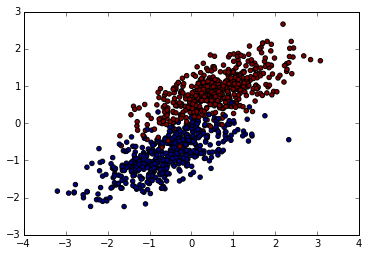

In [379]:
def dataset_fixed_cov(x1MeanDistance,x2MeanDistance,numberOfSamples=1000):
    '''Generate 2 Gaussians samples with the same covariance matrix'''
    n, dim = numberOfSamples/2, 2
    np.random.seed(312003)
    C = np.array([[0., -0.23], [0.83, .23]])
# C = np.array([[0.01, 0], [0, 0.01]])
    X = np.r_[np.dot(np.random.randn(n, dim), C),
              np.dot(np.random.randn(n, dim), C) + np.array([x1MeanDistance, x2MeanDistance])]
    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    y = np.hstack((-np.ones(n), np.ones(n)))
    X_scaled=np.column_stack([X_scaled, np.ones([numberOfSamples])])
    random_seed = 10312003
    rng = np.random.RandomState(random_seed)
    permutation = rng.permutation(2*n)
    return X_scaled[permutation], y[permutation]
dataSet = dataset_fixed_cov(1,1)
plt.scatter(dataSet[0][:,0],dataSet[0][:,1],c=dataSet[1][:])

We write the objective function in term of the huber hinge loss function:
$$F(w):= \Vert w\Vert^2+\frac{C}{n}\sum_{i=1}^{n} l_{huber-hunge}(y,w^Tx)$$
where:
$$
l_{huber-hunge}(y,w^Tx) = \begin{cases} 0, & \mbox{if } yw^Tx>1+h\\ 
\frac{(1+h-yw^Tx)^2}{4h}, & \mbox{if } |1-yw^Tx|\le h \\
1-yw^Tx, & \mbox{if } yw^Tx< 1-h
\end{cases}
$$

Than the gradient is:
$$\frac{\partial F(w)}{\partial w_i}:= 2w_i+\frac{C}{n}\sum_{i=1}^{n} \frac{\partial l_{huber-hunge}(y,w^Tx)}{\partial w_i}$$
where:
$$
\frac{\partial l_{huber-hunge}(y,w^Tx)}{\partial w_i} = \begin{cases} 0, & \mbox{if } yw^Tx>1+h\\ 
\frac{-yx_i(1+h-yw^Tx)}{2h}, & \mbox{if } |1-yw^Tx|\le h \\
-yx_i, & \mbox{if } yw^Tx< 1-h
\end{cases}
$$

In [83]:
def compute_obj(w,data,y):
    h=0.5
    lossSum=0
    #Understand what C is:
    C=1
    for iIter,x in enumerate(data):
        p = y[iIter]*np.dot(x,w)
        lossSum += 0 if p>1+h else (1-p if p<1-h else ((1+h-p)**2)/(4*h))
    return np.dot(w,w)+C*lossSum/len(data)

In [85]:
def compute_grad(w,data,y):
    h = 0.5
    C=1
    lossSum=0
    for iIter,x in enumerate(data):
        p = y[iIter]*np.dot(x,w)
        lossSum += 0 if p>1+h else (-y[iIter]*x if p<1-h else -y[iIter]*x*(1+h-p)/(2*h))
    return 2*w+C*lossSum/len(data)
    

## 2.1.3 Numerical Check
We whant the gradient of the objective function to be close to:
$$
\lim_{\epsilon\rightarrow 0}\frac{F(w+\epsilon\Delta)-F(w-\epsilon\Delta)}{2\epsilon}
$$
Changing the value of w in the code below it's possible to check the difference between this quantity and the computed gradient in it's three direction.

In [285]:
def numeric_check(delta,epsilon):
    return (compute_obj(w+epsilon*delta,dataSet[0],dataSet[1])-
            compute_obj(w-epsilon*delta,dataSet[0],dataSet[1]))/(2*epsilon)

w=np.array([1.5,3,2.7])
epsilon=0.001
grad=compute_grad(w,dataSet[0],dataSet[1])
print grad[0]-numeric_check(np.array([1,0,0]),epsilon)
print grad[1]-numeric_check(np.array([0,1,0]),epsilon)
print grad[2]-numeric_check(np.array([0,0,1]),epsilon)


1.44684264569e-12
4.39648317752e-13
2.30304664228e-12


## 2.1.4 Gradient Descent

In [323]:
def my_gradient_descent(data,y,eta=0.11,maxiter=1000,plot=True,backtracking=False,stopCriteria=""):
    w=np.zeros(3)
    objectiveFunction=[]
    missClassificationError=[]
    alpha = 0.4
    beta = 0.9
    rho=0.9
    for nIter in range(maxiter):
        if(backtracking) and nIter==0:
            print "Value of eta changing while backtracking: "
            while not (compute_obj(w-eta*compute_grad(w,data,y),data,y)<=compute_obj(w,data,y)-
                  alpha*eta*np.abs(np.dot(compute_grad(w,data,y),compute_grad(w,data,y)))**2):
                if plot:
                    print eta
                eta = beta*eta
        #print w
        grad=compute_grad(w,data,y)
        w=w- eta*grad
        objectiveFunction.append(compute_obj(w,data,y))
        missClassificationError.append( (np.dot(data,w)*y<0).sum())
        if stopCriteria=="":
            epsilon=0
        elif stopCriteria == "epsilon":
            epsilon=10**(-3)
        if stopCriteria == "epsilon" and LA.norm(grad)<epsilon:
            print "stopCriteria: ",stopCriteria
            print "Stopped for not changing gradient. Last iteration:",nIter
            break
        elif stopCriteria == "missError" and nIter>11 \
            and missClassificationError[-1]>rho*min(missClassificationError[-11:-2]):
            print "Stopped for not changing missclassification error. Last iteration:",nIter
            print missClassificationError[-10:-1] 
            print missClassificationError[-1]
            break
    if(plot):
        plt.plot(range(len(objectiveFunction)),objectiveFunction)
        plt.title("Objective function in first 100 iteration")
        plt.xlabel("iteration number")
        plt.ylabel("objective function")
        plt.xlim(0,100)
        plt.show()
        plt.clf()
        plt.clf()
        plt.plot(range(len(missClassificationError)),missClassificationError)
        plt.xlabel("iteration number")
        plt.ylabel("missclassification error in first 100 iteration")
        plt.xlim(0,100)
        plt.show()
    
    return w

In [311]:
def my_svm(trainData,testData,k,stopCrit="",showPlot=False,backtr=False,eta=1):
    w=np.zeros(3)
    if (backtr):
        eta0=1
    else:
        eta0=0.1*(1.1)**k
    wT=my_gradient_descent(trainData[0],trainData[1],eta=eta0,plot=showPlot,backtracking=backtr,stopCriteria=stopCrit)
    miss_error=(np.dot(testData[0],wT)*testData[1]<0).sum()
    print "Learned w: ",wT
    print "missclassification on Test data: ",miss_error

Fixing $\eta=0.1(1.1)^k$ and we start to increase $k$. for $k=1$ the convergence occurse after 6 iteration more or less. For $k$ bigger the convergence could be more fast (just 2 iteration if $k=10$). But if $k$ is too big $k>18$ the changes in the step are to big to stop in the minimum and we can observe instability.

Following the plots for k=1 ($\eta=0.11$, stable case) and k=19 ($\eta=0.61$, instable case):

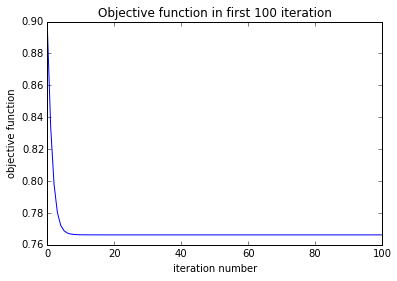

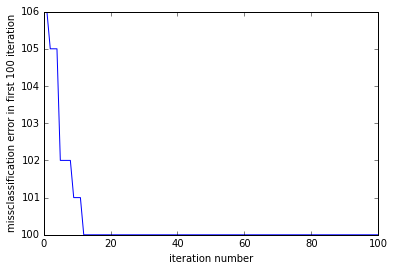

Learned w:  [ 0.20810598  0.35300281  0.00197451]
missclassification on Test data:  100


In [314]:
trainData = dataset_fixed_cov(1,1,1000)
testData = dataset_fixed_cov(1,1,1000)
my_svm(trainData,testData,1,stopCrit="",showPlot=True,backtr=False)

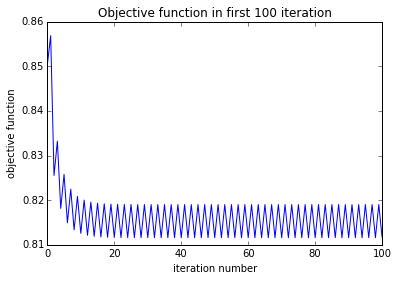

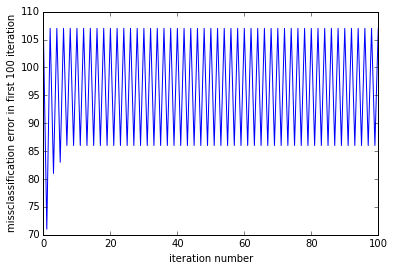

Learned w:  [ 0.08042607  0.22628457  0.0042562 ]
missclassification on Test data:  86


In [318]:
my_svm(trainData,testData,19,stopCrit="",showPlot=True,backtr=False)

Implementing the backtracking line search the convergence happens sooner but in the first iteration there is more instability and more oscilations. Also, timing the operformance, the appling the backtracking line search result in slowing down the algorithm. 

Value of eta changing while backtracking: 
1
0.9
0.81
0.729
0.6561
0.59049
0.531441


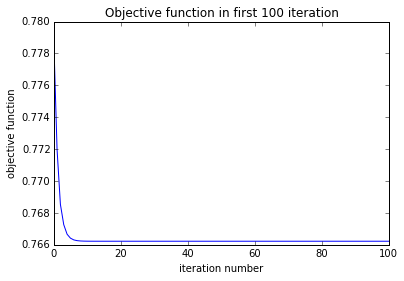

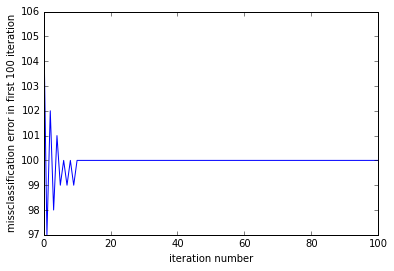

Learned w:  [ 0.20810598  0.35300281  0.00197451]
missclassification on Test data:  100


In [315]:
my_svm(trainData,testData,1,stopCrit="",showPlot=True,backtr=True)

In [316]:
%timeit my_svm(trainData,testData,1,stopCrit="",showPlot=False,backtr=False)


Learned w:  [ 0.20810598  0.35300281  0.00197451]
missclassification on Test data:  100
Learned w:  [ 0.20810598  0.35300281  0.00197451]
missclassification on Test data:  100
Learned w:  [ 0.20810598  0.35300281  0.00197451]
missclassification on Test data:  100
Learned w:  [ 0.20810598  0.35300281  0.00197451]
missclassification on Test data:  100
1 loops, best of 3: 6.03 s per loop


In [325]:
%timeit my_svm(trainData,testData,1,stopCrit="",showPlot=False,backtr=True)

Value of eta changing while backtracking: 
Learned w:  [ 0.20810598  0.35300281  0.00197451]
missclassification on Test data:  100
Value of eta changing while backtracking: 
Learned w:  [ 0.20810598  0.35300281  0.00197451]
missclassification on Test data:  100
Value of eta changing while backtracking: 
Learned w:  [ 0.20810598  0.35300281  0.00197451]
missclassification on Test data:  100
Value of eta changing while backtracking: 
Learned w:  [ 0.20810598  0.35300281  0.00197451]
missclassification on Test data:  100
1 loops, best of 3: 6.18 s per loop


[ 0.08042607  0.22628457  0.0042562 ]


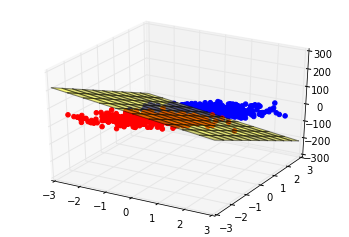

In [326]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure("Stochastic")
ax = fig.add_subplot(111, projection='3d')
dataPlot =np.asarray(dataSet[0])
colors = ["red", "blue"]
idx = np.where(dataSet[1] == -1)
ax.scatter(dataPlot[idx,0], dataPlot[idx,1], dataPlot[idx,2], color=colors[0],alpha=1)
idx = np.where(dataSet[1] == 1)
ax.scatter(dataPlot[idx,0], dataPlot[idx,1], dataPlot[idx,2], color=colors[1],alpha=1)
#Piano che passa per due punti: 
point  = np.array([0, 0, 0])
normal = np.array(wT)
d = -point.dot(normal)
xx, yy = np.meshgrid(np.linspace(-3,3,100), np.linspace(-3,3,100))

# calculate corresponding z
z = (-normal[0] * xx - normal[1] * yy - d) * 1. /normal[2]

# plot the surface
#plt3d = plt.figure().gca(projection='3d')
ax.plot_surface(xx, yy, z,color="yellow",alpha=0.5)
plt.xlim(-3,3)
plt.ylim(-3,3)


print wT
plt.show()
#print np.linspace(-2,2,100)

## Stopping criteria


stopCriteria:  epsilon
Stopped for not changing gradient. Last iteration: 22


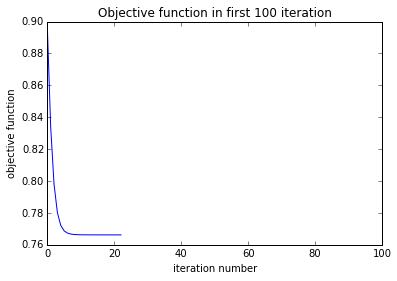

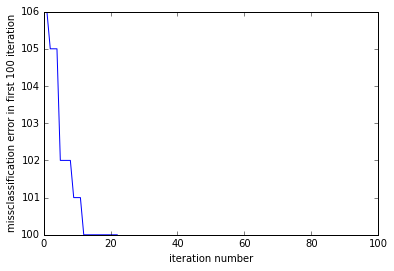

Learned w:  [ 0.20831665  0.35276893  0.00196093]
missclassification on Test data:  100


In [327]:
my_svm(trainData,testData,1,stopCrit="epsilon",showPlot=True,backtr=False)

Stopped for not changing missclassification error. Last iteration: 12
[105, 105, 102, 102, 102, 102, 101, 101, 101]
100


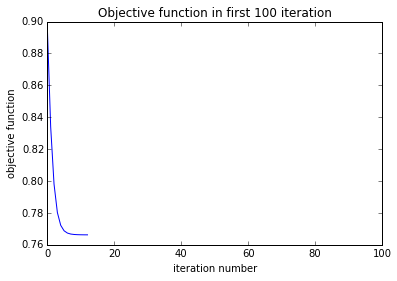

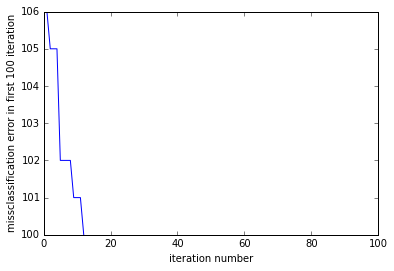

Learned w:  [ 0.21009498  0.34921045  0.00171491]
missclassification on Test data:  100


In [328]:
my_svm(trainData,testData,1,stopCrit="missError",showPlot=True,backtr=False)

In [329]:
def compute_grad_single_point(w,x,y):
    h = 0.5
    C=1
    p = y*np.dot(x,w)
    lossGrad = 0 if p>1+h else (-y*x if p<1-h else -y*x*(1+h-p)/(2*h))
    return 2*w+lossGrad

In [372]:
def my_sgd(data,y,eta=0.11,maxiter=10,plot=True,backtracking=False,epsilon=0,stopCriteria = "missError"):
    w=np.zeros(3)
    objectiveFunction=[]
    missClassificationError=[]
    rho=0.9
    done=False
    for nIter in range(maxiter):
        eta=eta/(3+nIter)
        for nPoint,dataPoint in enumerate(data):
            grad=compute_grad_single_point(w,dataPoint,y[nPoint])
            w=w- eta*grad
            objectiveFunction.append(compute_obj(w,data,y))
            missClassificationError.append( (np.dot(data,w)*y<0).sum())  
        totalGrad = compute_grad(w,data,y)
        print LA.norm(totalGrad)
        
        if stopCriteria=="":
            epsilon=0
        elif stopCriteria == "epsilon":
            epsilon=10**(-1)
        if stopCriteria == "epsilon" and LA.norm(totalGrad)<epsilon:
            print "stopCriteria: ",stopCriteria
            print "misclassification in the last iteration ",missClassificationError[-10:-1]
            print "Stopped for not changing gradient. Last iteration:",nIter
            done=True
            break
        elif stopCriteria == "missError" and nIter>11 \
            and missClassificationError[-1]>rho*min(missClassificationError[-11:-2]):
            print "Stopped for not changing missclassification error. Last iteration:",nIter
            print missClassificationError[-10:-1] 
            print missClassificationError[-1]
            break
            
    if(plot):
        plt.plot(range(len(objectiveFunction)),objectiveFunction)
        plt.title("Objective function in the 1000 iteration")
        plt.xlabel("iteration number")
        plt.ylabel("objective function")
        plt.show()
        plt.clf()
        plt.plot(range(len(objectiveFunction)),missClassificationError)
        plt.xlabel("iteration number")
        plt.ylabel("missclassification error function")
        #plt.xlim(0,20)
        plt.show()
    
    return w
        

1.0790780682
0.575290188318
0.250787294638
0.0634112815294
stopCriteria:  epsilon
misclassification in the last iteration  [103, 101, 103, 101, 101, 101, 103, 103, 101]
Stopped for not changing gradient. Last iteration: 3


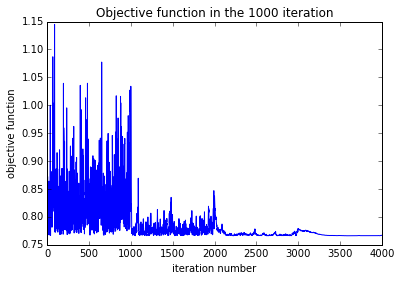

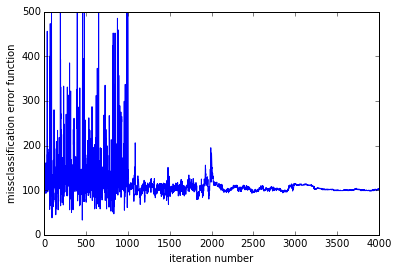

array([ 0.20750342,  0.35186684,  0.02841531])

In [373]:
my_sgd(dataSet[0],dataSet[1],eta=0.46,plot=True,stopCriteria = "epsilon")
#for nPoint,dataPoint in enumerate(dataSet[0]):
#    print dataSet[1][nPoint]

In [ ]:
bigDataSet= dataset_fixed_cov(1,1,10**3)

In [337]:
import time

start = time.time()
my_gradient_descent(bigDataSet[0],bigDataSet[1],eta=0.11,plot=False,stopCriteria="missError")
end = time.time()
print end - start




689.500851154


In [380]:
import time

start = time.time()
my_sgd(bigDataSet[0],bigDataSet[1],eta=0.11,plot=False,stopCriteria="epsilon")
end = time.time()
print end - start

0.261603874917
0.139603716789
0.0543947181533
stopCriteria:  epsilon
misclassification in the last iteration  [1171, 1175, 1174, 1176, 1177, 1177, 1179, 1177, 1178]
Stopped for not changing gradient. Last iteration: 2
545.431111097
